

Olá estudante!

Me chamo Rafael Meirelles e irei revisar o seu projeto hoje e em eventuais futuras submissões até que ele cumpra todos os requisitos para o aceite.
Conte comigo nessa jornada e não se preocupe se precisar ajustar alguns detalhes, é parte do processo e fundamental para que você exercite os conceitos que vem aprendendo e assim melhore a qualidade dos seus códigos e análises.

**Peço que mantenha e não altereos comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender os meus feedbacks no seu notebook. Funciona assim:


<div class="alert alert-danger">
<strong>Vermelho</strong>

Erro que precisa ser consertado, caso contrário, seu projeto não pode ser aceito

</div>

<div class="alert alert-warning">
<strong>Amarelo</strong>

Alerta de um erro não crítco, mas que pode ser corrigido para melhoria geral no seu código/análise

</div>

<div class="alert alert-success">
<strong>Verde</strong>

Elogios
</div>

<div class="alert alert-info">
<strong>Comentário do estudante</strong>

Use uma caixa azul como essa para eventuais comentários que você gostaria de fazer para mim.
</div>








<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Trabalho muito sólido com o projeto! Gostei muito.
    
    
Parabéns pela aprovação e até breve!
</div>

## Inicialização

## Carregar os dados

O conjunto de dados está armazenado na pasta `\\datasets\\faces\\`, lá você encontra 
- A pasta `final_files` com 7,6k fotos
- O arquivo `labels.csv` com rótulos, com duas colunas: `file_name` e `real_age`

Dado que o número de arquivos de imagem é bastante alto, é aconselhável evitar a leitura de todos de uma vez, o que consumiria muito recursos computacionais. Recomendamos que você crie um gerador com o ImageDataGenerator. Este método foi explicado no Capítulo 3, Lição 7 deste curso.

O arquivo de etiqueta pode ser carregado como um arquivo CSV usual.

### Importando Bibliotecas

In [72]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import ReduceLROnPlateau

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

In [7]:
print("GPU disponível:", tf.config.list_physical_devices("GPU"))

GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Carregando Dados

In [8]:
# Carregando arquivos externos de dados - rótulos
labels = pd.read_csv("datasets\\faces\\labels.csv")

In [9]:
# Conferindo estrutura básica do dataframe de rótulos
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [10]:
# Visualizando uma amostra aleatória
labels.sample(5, random_state=333)

,file_name,real_age
3930,003930.jpg,35
4445,004445.jpg,14
6214,006217.jpg,20
7218,007236.jpg,5
5561,005561.jpg,32


In [11]:
# Conferindo se há linhas duplicadas
labels[labels.duplicated()]

,file_name,real_age


O dataframe dos rótulos possui apenas 2 colunas com dados sobre *7591* imagens do banco de dados:

- `file_name`: Nome dos arquivos de cada imagem em .jpg, tipo: *string*;
- `real_age`: Idade real das pessoas nas fotos, tipo *int*;

Não há valores ausentes nem duplicados.

In [12]:
# Conferindo a estrutura da pasta onde os dados estão localizados
for root, dirs, files in os.walk("datasets\\faces\\"):
    level = root.replace("datasets\\faces\\", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}\\")
    subindent = " " * 4 * (level + 1)
    for file in files[:5]:
        print(f"{subindent}{file}")

\
    labels.csv
final_files\
    000000.jpg
    000001.jpg
    000002.jpg
    000003.jpg
    000004.jpg


In [13]:
# Conferindo o tamanho original das imagens
image_path = "datasets\\faces\\final_files\\"
image_files = os.listdir(image_path)

for img_name in image_files[:5]:  # Pegando 5 imagens aleatórias
    img = Image.open(os.path.join(image_path, img_name))
    print(f"{img_name}: {img.size}")  # Mostra (largura, altura)

000000.jpg: (114, 114)
000001.jpg: (784, 784)
000002.jpg: (133, 133)
000003.jpg: (370, 370)
000004.jpg: (212, 212)


Todas as imagens estão em uma mesma pasta, seus rótulos estão no dataframe *labels*, então será necessário utilizar outro fluxo para o gerador de imagens: em vez de `flow_from_directory()` usarei `flow_from_dataframe()`.

Sobre os tamanhos das imagens, são bem variados, porém todos respeitam a proporção quadrada, podemos importá-las no tamanho padrão para uso na arquitetura ResNet: *(224, 224)*.

In [14]:
# Criando um gerador de imagens para análise de uma amostra das imagens
datagen = ImageDataGenerator(rescale=1 / 255.0)

In [15]:
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory="datasets\\faces\\final_files\\",
    x_col="file_name",  # Onde estão os nomes dos arquivos a serem acessados;
    y_col="real_age",  # Onde estão os rótulos;
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",  # Especifica o rótulo como valor contínuo, por não serem categorias.
    seed=333,
)

Found 7591 validated image filenames.


## EDA

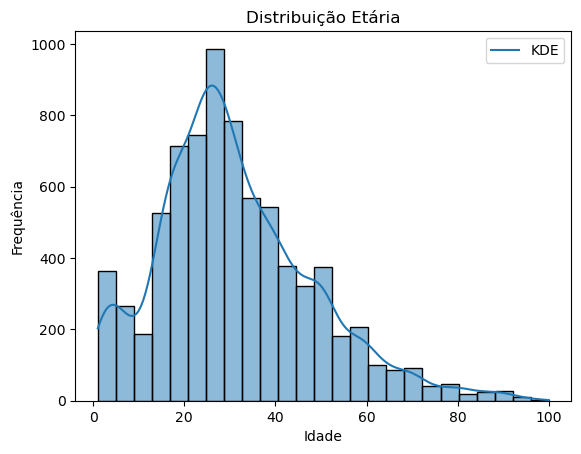

In [16]:
# Conferindo a distribuição etária no conjunto de dados
plot = sns.histplot(
    data=labels,
    bins=25,
    kde=True,
)

# Adicionando legendas
plot.lines[0].set_label("KDE")

plot.set_title("Distribuição Etária")  # Título do gráfico
plot.set_xlabel("Idade")  # Rótulo do eixo X
plot.set_ylabel("Frequência")  # Rótulo do eixo Y

plot.legend()

Text(0.5, 0, 'Idade')

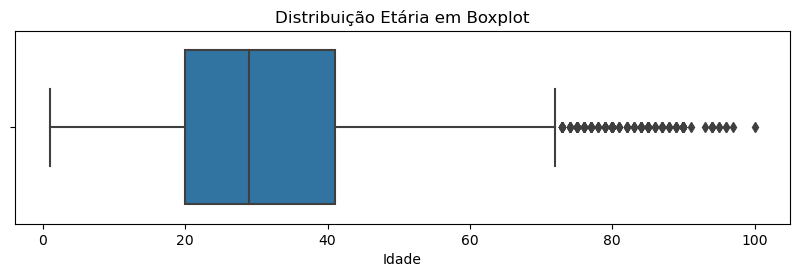

In [17]:
# Imprimindo um boxplot da distribuição etária
plt.figure(figsize=(10, 2.5))

sns.boxplot(
    x=labels["real_age"],
)

plt.title("Distribuição Etária em Boxplot")  # Título do gráfico
plt.xlabel("Idade")  # Rótulo do eixo X

Há um número significativamente maior de amostras na faixa etária entre **20 e 40 anos** com um pico de amostras de pessoas entre 25 e 30 anos.

Também há amostras de pessoas menores de idade e até pouco mais de 70 anos.

Os outliers são as amostras a partir de 75 anos de idade.

Seria bom ter mais amostras de menores de 21 anos para melhor ainda mais o treinamento do modelo.

### Visualizando algumas amostras

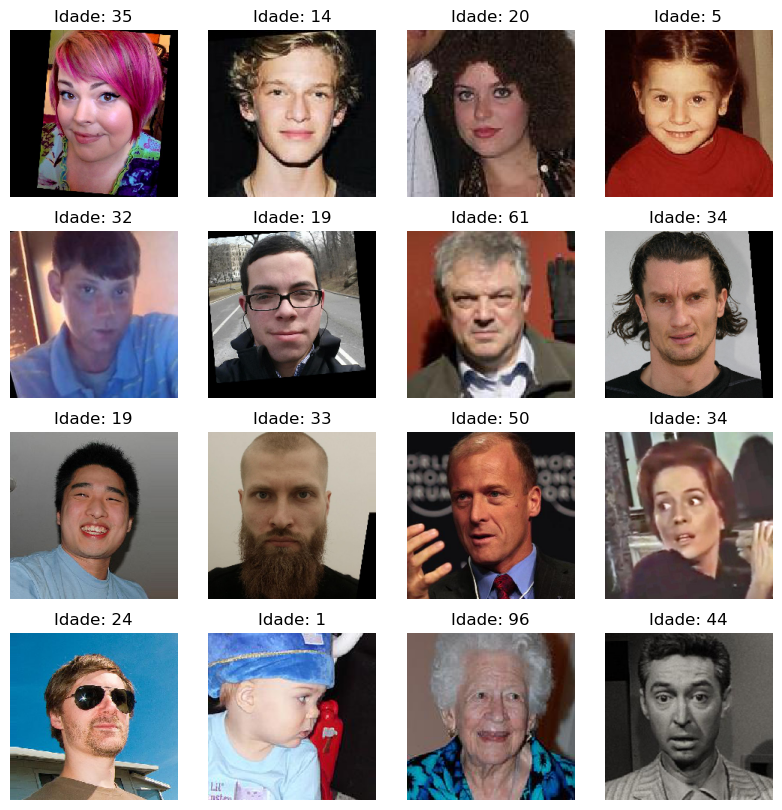

In [18]:
# Gerando visualização das primeiras 16 amostras do primeiro batch gerado pelo datagen
images, labels1 = next(datagen_flow)
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)  # Layout 4x4
    img = Image.fromarray((images[i] * 255).astype("uint8"))  # Multiplica e converte
    plt.imshow(img)  # Exibe a imagem
    plt.title(f"Idade: {int(labels1[i])}")  # Exibe a idade
    plt.axis("off")  # Remove os eixos

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()  # Mostra o grid

O conjunto de dados possui amostras bem variadas sobre as diferentes idades, tanto em questões de etnia como em épocas em que as fotos foram tiradas e diferentes expressões faciais, será uma ótima base de aprendizado!

Algumas imagens podem confundir o modelo, como o homem de 32 anos exibido nesta amostra, porém são todas imagens claras e de pessoas reais com diferentes adereços e em diferentes ângulos.

<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Excelente trabalho checando a consistência dos dados.

Sempre importante para garantir uma análise robusta!
</div>

## Modelagem

Defina as funções necessárias para treinar seu modelo na plataforma GPU e construa um único script contendo todas elas junto com a seção de inicialização.
Para facilitar essa tarefa, você pode defini-las neste notebook e executar um código pronto na próxima seção para compor o script automaticamente.
As definições abaixo também serão verificadas pelos revisores do projeto, para que possam entender como você construiu o modelo.

In [19]:
# Exportando o dataset para rodar em minha máquina pessoal
import zipfile
import os

# Defina o caminho da pasta
folder_path = "datasets\\faces\\"

# Nome do arquivo ZIP
zip_filename = "faces_dataset.zip"

# Compactar a pasta

with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:

    for root, dirs, files in os.walk(folder_path):

        for file in files:

            zipf.write(
                os.path.join(root, file),
                os.path.relpath(os.path.join(root, file), folder_path),
            )

print(f"Dataset exportado para: {zip_filename}")

Dataset exportado para: faces_dataset.zip


In [20]:
from IPython.display import FileLink

# Link para o arquivo gerado
FileLink(zip_filename)

c:\Users\Georgia Cavallaro\OneDrive\Documentos\Estudos\BOOTCAMP Ciência de Dados - Triple Ten!\15- Sprint 15\faces_dataset.zip

In [21]:
def load_train(dataframe, path):
    """
    Carrega a parte de treinamento do conjunto de dados a partir do caminho
    """

    # coloque seu código aqui
    train_datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=path,
        x_col="file_name",  # Onde estão os nomes dos arquivos no dataframe a serem acessados;
        y_col="real_age",  # Onde estão os rótulos;
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",  # Especifica o rótulo como valor contínuo, por não serem categorias.
        subset="training",
        seed=333,
    )

    return train_gen_flow

In [22]:
def load_test(dataframe, path):
    """
    Carrega a parte de validação/teste do conjunto de dados a partir do caminho
    """

    # coloque seu código aqui
    train_datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.25)
    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=path,
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        seed=333,
    )

    return test_gen_flow

In [89]:
def create_model(input_shape=(224, 224, 3), learning_rate=0.001):
    """
    Define o modelo
    """

    # coloque seu código aqui
    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
    )
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mae"],
    )

    return model

In [96]:
def train_model(
    model,
    train_data,
    test_data,
    epochs=30,
    steps_per_epoch=None,
    validation_steps=None,
):
    """

    Treina o modelo de acordo com os parâmetros

    """

    # coloque seu código aqui
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.0003, patience=2, min_lr=1e-6, verbose=1
    )

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[reduce_lr],
    )

    return model

### Preparar o Script para execução na plataforma GPU

Dado que você definiu as funções necessárias, você pode compor um script para a plataforma GPU, baixá-lo através do menu "Arquivo|Abrir..." e carregá-lo posteriormente para execução na plataforma GPU.

Nota: O script também deve incluir a seção de inicialização. Um exemplo disso é mostrado abaixo.

In [25]:
# preparar um script para ser executado na plataforma GPU

init_str = """# -*- coding: utf-8 -*-

import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open("run_model_on_gpu.py", "w", encoding="utf-8") as f:

    f.write(init_str)
    f.write("\n\n")

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write("\n\n")

### Saída

Coloque a saída da plataforma GPU como uma célula Markdown aqui.

In [26]:
path = "datasets\\faces\\final_files\\"
train_gen_flow = load_train(labels, path)

Found 5694 validated image filenames.


In [27]:
test_gen_flow = load_test(labels, path)

Found 1897 validated image filenames.


In [97]:
model = create_model(learning_rate=0.0005)

In [98]:
train_model(model, train_gen_flow, test_gen_flow, epochs=15)

Epoch 1/15
178/178 - 59s - loss: 197.9040 - mae: 10.5865 - val_loss: 159898.1875 - val_mae: 399.4669
Epoch 2/15
178/178 - 49s - loss: 106.3281 - mae: 7.8485 - val_loss: 315.6169 - val_mae: 13.1856
Epoch 3/15
178/178 - 50s - loss: 78.3799 - mae: 6.8040 - val_loss: 340.0262 - val_mae: 13.8123
Epoch 4/15
178/178 - 49s - loss: 45.9180 - mae: 5.2408 - val_loss: 228.4563 - val_mae: 11.1064
Epoch 5/15
178/178 - 50s - loss: 31.5514 - mae: 4.3216 - val_loss: 129.7957 - val_mae: 8.6378
Epoch 6/15
178/178 - 50s - loss: 26.6135 - mae: 3.9494 - val_loss: 82.1771 - val_mae: 6.8820
Epoch 7/15
178/178 - 50s - loss: 21.7063 - mae: 3.5603 - val_loss: 87.9493 - val_mae: 7.2038
Epoch 8/15
178/178 - 50s - loss: 17.3569 - mae: 3.1736 - val_loss: 77.3451 - val_mae: 6.6442
Epoch 9/15
178/178 - 50s - loss: 16.0022 - mae: 3.0600 - val_loss: 92.9874 - val_mae: 7.1092
Epoch 10/15
178/178 - 50s - loss: 15.3201 - mae: 3.0153 - val_loss: 100.3199 - val_mae: 7.3329

Epoch 00010: ReduceLROnPlateau reducing learning ra

<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Modelo treinado adequadamente e saída do modelo compartilhada com valores adequados.
</div>

## Conclusões

### Processamento e Preparação dos Dados

- O conjunto de dados conta com **7.591 imagens** e seus respectivos rótulos armazenados no arquivo `labels.csv`.

- Não foram encontrados valores ausentes nem duplicados no conjunto de rótulos.

- As imagens possuem tamanhos variados, mas mantêm a proporção quadrada, facilitando a padronização para a arquitetura **ResNet50** no formato *(224, 224)*.

- Para melhor eficiência no uso de recursos computacionais, utilizou-se o **ImageDataGenerator** com `flow_from_dataframe()`.

### Análise Exploratória dos Dados (EDA)

- A análise da distribuição etária mostrou que a maioria das amostras está entre **20 e 40 anos**, com um pico entre **25 e 30 anos**.

- Foram identificados outliers acima de 75 anos.

- A base de dados inclui variedade em **etnias, épocas e expressões faciais**, tornando-se adequada para aprendizado profundo.

- Sugere-se um aumento de amostras para idades abaixo de **21 anos**, visando um melhor balanceamento do dataset.

### Construção e Treinamento do Modelo

- O modelo foi baseado na arquitetura ResNet50, utilizando camadas adicionais de **GlobalAveragePooling2D e Dense**.

- O otimizador **Adam** foi empregado com uma taxa de aprendizado inicial de **0.0005**.

- O treinamento foi realizado em **15 épocas** com batch size de 32.

- Utilizou-se a estratégia de *redução da taxa de aprendizado adaptativa (ReduceLROnPlateau)* para otimizar a convergência do modelo.

### Desempenho do Modelo

- O modelo começou com um erro médio absoluto (MAE) inicial de 399.46 e finalizou em **6.29 para o conjunto de validação**.

- A função de perda (MSE) apresentou uma redução significativa ao longo das épocas, indicando aprendizado adequado.

- Apesar da melhora, há indícios de *overfitting*, uma vez que a validação apresentou uma perda relativamente maior.

### Possíveis Melhorias

- Aumentar a diversidade de dados, especialmente para faixas etárias sub-representadas.

- Experimentar outras arquiteturas, como *EfficientNet* ou *MobileNet*, que podem melhorar a acurácia com menos parâmetros treináveis.

- Implementar técnicas de aumento de dados *(Data Augmentation)* para aumentar a variabilidade e reduzir overfitting.

- Ajustar hiperparâmetros, como a *profundidade da rede*, para otimizar o desempenho.

### Conclusão Geral

O projeto demonstrou a viabilidade de usar redes neurais convolucionais para estimar idades a partir de imagens faciais. A abordagem utilizada permitiu alcançar um erro médio absoluto de aproximadamente **6.29 anos**, o que já representa um resultado promissor. Melhorias adicionais podem ser exploradas para reduzir ainda mais esse erro e aumentar a generalização do modelo em diferentes faixas etárias.

# Checklist

- [x]  O notebook foi aberto
- [x]  O código está livre de erros 
- [x]  As células com código foram organizadas por ordem de execução
- [x]  A análise exploratória dos dados foi realizada 
- [x]  Os resultados da análise exploratória dos dados são apresentados no caderno final 
- [x]  O valor EAM do modelo não é superior a 8
- [x]  O código de treinamento do modelo foi copiado para o notebook final 
- [x]  A saída do treinamento do modelo foi copiada para o notebook final 
- [x]  As conclusões foram fornecidas com base nos resultados do treinamento do modelo